Relevant code to ensemble our best models and performing F1 score weighting of the ensemble together with tabu search for importance inside the ensemble. This code cannot be run completely without the model files however we left the metadata with some prints

In [ ]:
import tensorflow.keras as tfk
import tensorflow as tf
import numpy as np
import pickle

import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import tensorflow as tf
import seaborn as sns

In [ ]:
import tensorflow as tf
import tensorflow.keras as tfk
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount("./gdrive")

Mounted at ./gdrive


# Utils Functions

In [ ]:
def show_confusion(model, validation_dataset):
  Y_pred = model.predict(validation_dataset)
  y_pred = np.argmax(Y_pred, axis=1)
  y_test= np.concatenate([y for x, y in validation_dataset], axis=0)

  cm = confusion_matrix(y_test, y_pred)

  disp = ConfusionMatrixDisplay(confusion_matrix=cm)

  disp.plot(cmap=plt.cm.Blues)
  plt.show()

  f1_scores = f1_score(y_test, y_pred, average=None)
  mean_f1 = np.mean(f1_scores)

  print(f"\nF1 scores: {f1_scores}")
  print(f"\nMean F1 : {mean_f1}")
  print(f"\nAccuracy : {accuracy_score(y_test, y_pred)}")

In [ ]:
def get_validation_acc(model, validation_dataset):
  Y_pred = model.predict(validation_dataset)
  y_pred = np.argmax(Y_pred, axis=1)
  y_test= np.concatenate([y for x, y in validation_dataset], axis=0)
  return accuracy_score(y_test, y_pred)

In [ ]:
def from_raw_to_dataframe(x_raw, y_raw):
    tabular_list = []
    for i_sample, x in enumerate(x_raw):
        for i_time, xx in enumerate(x):
            tabular_list.append([i_sample, i_time] + list(xx) + [y_raw[i_sample]])
    df_res = pd.DataFrame(tabular_list).rename(columns={
        0: 'sample_id',
        1: 'time',
        2: 'feat_1',
        3: 'feat_2',
        4: 'feat_3',
        5: 'feat_4',
        6: 'feat_5',
        7: 'feat_6',
        8: 'label'}, inplace=False, errors='raise')
    return df_res

In [ ]:
def build_sequences(df):
    # Sanity check to avoid runtime errors
    #assert window % stride == 0
    dataset = []
    labels = []
    for id in df['sample_id'].unique():
        # Take only meaningful features
        temp = df[df['sample_id'] == id][['feat_1','feat_2','feat_3','feat_4','feat_5','feat_6']].values
        # Save the label
        label = df[df['sample_id'] == id]['label'].values[0]
        labels.append(label)
        dataset.append(temp)

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [ ]:
def apply_scaler_to_new_data(x,y,scaler):
  x_original_tabular = from_raw_to_dataframe(x, y)
  x_original_tabular[['feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6']] = scaler.transform(x_original_tabular[['feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6']])
  agg_x, agg_y = build_sequences(x_original_tabular)
  return agg_x, agg_y

In [ ]:
def get_f1_scores(model, validation_dataset):
    Y_pred = model.predict(validation_dataset)
    y_pred = np.argmax(Y_pred, axis=1)
    y_test= np.concatenate([y for x, y in validation_dataset], axis=0)
    f1_scores = f1_score(y_test, y_pred, average=None)
    return f1_scores

In [ ]:
def get_probability_vect(size):
  # build a list/array of random numbers
  numbers = []
  for _ in range(size):
      numbers.append(random.random())
  # normalise the original list using the sum
  return np.array(numbers) / np.sum(numbers)
  

In [ ]:
def get_random_vect(size):
  # build a list/array of random numbers
  numbers = []
  for _ in range(size):
      numbers.append(random.uniform(0, 1/size))
  # normalise the original list using the sum
  return np.array(numbers) / np.sum(numbers)

# Load Data

In [ ]:
# load scaler
with open("./gdrive/MyDrive/ann_dataset/modelss/scaler.p", "rb") as f:
  scaler = pickle.load(f)

In [ ]:
# load data split
with open("./gdrive/MyDrive/ann_dataset/HW2/dataUsed/train_test_objKeep9", "rb") as f:
  x_train, x_test, y_train, y_test = pickle.load(f)

In [ ]:
x_train_norm, y_train_norm= apply_scaler_to_new_data(x_train, y_train, scaler)
x_test_norm, y_test_norm = apply_scaler_to_new_data(x_test, y_test, scaler)

In [ ]:
# create dataset tf
BATCH_SIZE = 32
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_norm, y_train_norm)).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_norm, y_test_norm)).batch(BATCH_SIZE)

In [ ]:
# paths of models to ensemble
paths = ['./gdrive/MyDrive/ann_dataset/models/BILSTM_0700Fullbi',
        './gdrive/MyDrive/ann_dataset/models/BILSTM_07119Fullbi',
        './gdrive/MyDrive/ann_dataset/models/BILSTM_07139Fullbi',
        './gdrive/MyDrive/ann_dataset/models/BILSTM_07242Fullbi',
        './gdrive/MyDrive/ann_dataset/models/BILSTM_07325Fullbi',
        './gdrive/MyDrive/ann_dataset/models/BILSTM_073Fullbi',
        './gdrive/MyDrive/ann_dataset/models/BILSTM_0781Fullbi',
        './gdrive/MyDrive/ann_dataset/models/M0709',
        './gdrive/MyDrive/ann_dataset/models/model07160493731498718']

In [ ]:
# load models
models = []
for p in paths:
  models.append(tf.keras.models.load_model(p, compile=False))

for m in models:
  m.compile()

# Build ensemble with average

In [ ]:
# buil ensemble  NOT weighted averate but normal average
for i,m in enumerate(models):
    m._name = f"{m.name}{i}"
model_input = tf.keras.Input(shape=(36, 6))
model_outputs = [model(model_input) for model in models]
ensemble_output = tfk.layers.Average()(model_outputs)
ensemble_model = tf.keras.Model(inputs=model_input, outputs=ensemble_output)

16/16 [==============================] - 26s 383ms/step


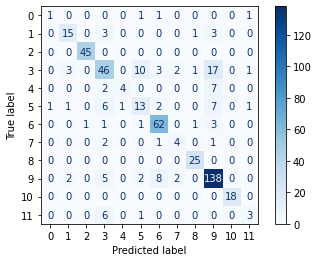


F1 scores: [0.33333333 0.69767442 0.98901099 0.5974026  0.44444444 0.43333333
 0.84931507 0.5        0.94339623 0.82882883 1.         0.375     ]

Mean F1 : 0.6659782699888687

Accuracy : 0.7695473251028807


In [ ]:
show_confusion(ensemble_model, test_dataset)

In [ ]:
# ensemble_model.summary()

In [ ]:
%load_ext cython

In [ ]:
%%cython
from __main__ import ensemble_model
name = "./gdrive/MyDrive/ann_dataset/modelss/BestEnsembleOnlyAvg"
ensemble_model.save(name)

# Weights models in the ensemble based on their F1 score in each class then dividing by the summ of all f1 scores for that class

In [ ]:
# CLASS weighting class
class WeightedAverageLayer(tf.keras.layers.Layer):
    def __init__(self, w, **kwargs):
        super(WeightedAverageLayer, self).__init__(**kwargs)
        self.w = w

    def call(self, inputs):
        #return tf.tensordot(tf.transpose(inputs), self.w, axes=1)
        cumsum = self.w[0] * inputs[0]
        for i, _ in enumerate(self.w[1:]):
            cumsum += self.w[i+1] * inputs[i+1]
        return cumsum

In [ ]:
# give importance to each prediction by the f1 score of the model for that class then normalize by total f1 score
W = []
for m in models:
    # stack the f1 scores of each model
    W.append(get_f1_scores(m, test_dataset))

W = np.array(W)

# sum columns, 12 element array expected
row_sums = np.sum(W, axis=0)

# rescale weights to sum to 1 columnwise
W_F1 = W / row_sums

W_F1

16/16 [==============================] - 2s 15ms/step


array([[0.        , 0.10171647, 0.10918961, 0.10903422, 0.10063292,
        0.12315027, 0.10915343, 0.08975885, 0.11472664, 0.10751696,
        0.11376871, 0.17097867],
       [0.25068051, 0.10721016, 0.10646787, 0.11496214, 0.13837026,
        0.1153312 , 0.10918223, 0.10685578, 0.11105539, 0.11091133,
        0.10393685, 0.1609211 ],
       [0.15952396, 0.09897795, 0.11018763, 0.1048613 , 0.03459257,
        0.13059562, 0.11413055, 0.11219857, 0.11105539, 0.11023108,
        0.11358813, 0.04559431],
       [0.17547636, 0.11140375, 0.11275014, 0.10263177, 0.14438636,
        0.10685097, 0.11232416, 0.11219857, 0.11685121, 0.11605112,
        0.1104329 , 0.10728074],
       [0.        , 0.12555343, 0.11153777, 0.13245638, 0.10542496,
        0.08830045, 0.1087597 , 0.08857782, 0.10678403, 0.11082935,
        0.11376871, 0.06513473],
       [0.21934545, 0.10954081, 0.11285918, 0.11427609, 0.13283545,
        0.0956035 , 0.11256711, 0.14959809, 0.10600742, 0.11287647,
        0.11358813,

In [ ]:
# build weighted ensemble with f1 scores
Wavg = WeightedAverageLayer(W_F1)

KeyboardInterrupt: ignored

In [ ]:
for i,m in enumerate(models):
    m._name = f"{m.name}{i}"
model_input = tf.keras.Input(shape=(36, 6))
model_outputs = [model(model_input) for model in models]
ensemble_output = Wavg(model_outputs)
ensemble_model = tf.keras.Model(inputs=model_input, outputs=ensemble_output)

In [ ]:
val_acc = show_confusion(ensemble_model, test_dataset)

In [ ]:
# save W_F1
with open(f"./gdrive/MyDrive/ann_dataset/W_ensemble/W_F1", "wb") as f:
      pickle.dump(W_F1, f)

['./gdrive/MyDrive/ann_dataset/W_ensemble/W0.7736625514403292',
 './gdrive/MyDrive/ann_dataset/W_ensemble/W0.7757201646090535',
 './gdrive/MyDrive/ann_dataset/W_ensemble/W07777777777777778',
 './gdrive/MyDrive/ann_dataset/W_ensemble/W0.779835390946502',
 './gdrive/MyDrive/ann_dataset/W_ensemble/importance0.7880658436213992',
 './gdrive/MyDrive/ann_dataset/W_ensemble/WW0.7880658436213992',
 './gdrive/MyDrive/ann_dataset/W_ensemble/WW0.7901234567901234',
 './gdrive/MyDrive/ann_dataset/W_ensemble/importance0.7901234567901234',
 './gdrive/MyDrive/ann_dataset/W_ensemble/WW0.7716049382716049',
 './gdrive/MyDrive/ann_dataset/W_ensemble/importance0.7716049382716049',
 './gdrive/MyDrive/ann_dataset/W_ensemble/WW0.7736625514403292',
 './gdrive/MyDrive/ann_dataset/W_ensemble/importance0.7736625514403292',
 './gdrive/MyDrive/ann_dataset/W_ensemble/WW0.7757201646090535',
 './gdrive/MyDrive/ann_dataset/W_ensemble/importance0.7757201646090535',
 './gdrive/MyDrive/ann_dataset/W_ensemble/importance0.77

In [ ]:
%load_ext cython

In [ ]:
MODEL_SOURCE = "./gdrive/MyDrive/ann_dataset/W_ensemble"
paths_W = []
for f in os.listdir(f"{MODEL_SOURCE}"):
    paths_W.append(f"{MODEL_SOURCE}/{f}")
paths_W

# 

# Create ensemble with a generic weight matrix W[model, class]

In [ ]:
# CLASS weighting class
class WeightedAverageLayer(tf.keras.layers.Layer):
    def __init__(self, w, **kwargs):
        super(WeightedAverageLayer, self).__init__(**kwargs)
        self.w = w

    def call(self, inputs):
        #return tf.tensordot(tf.transpose(inputs), self.w, axes=1)
        cumsum = self.w[0] * inputs[0]
        for i, _ in enumerate(self.w[1:]):
            cumsum += self.w[i+1] * inputs[i+1]
        return cumsum

16/16 [==============================] - 28s 431ms/step


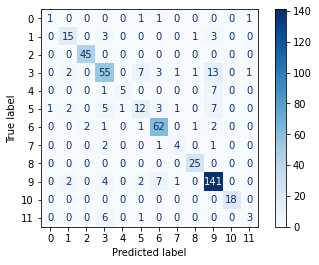


F1 scores: [0.33333333 0.69767442 0.97826087 0.6875     0.52631579 0.42857143
 0.84931507 0.53333333 0.94339623 0.85196375 1.         0.4       ]

Mean F1 : 0.6858053511677883

Accuracy : 0.7942386831275721


In [ ]:
# explore drive path
MODEL_SOURCE = "./gdrive/MyDrive/ann_dataset/W_ensemble"
paths_W = []
for f in os.listdir(f"{MODEL_SOURCE}"):
    paths_W.append(f"{MODEL_SOURCE}/{f}")
print(paths_W)

In [ ]:
with open('./gdrive/MyDrive/ann_dataset/W_ensemble/WF10.7942386831275721', "rb") as f:
 W = pickle.load(f)

In [ ]:
# using custom W weights for models
Wavg = WeightedAverageLayer(W)

In [ ]:
for i,m in enumerate(models):
    m._name = f"{m.name}{i}"
model_input = tf.keras.Input(shape=(36, 6))
model_outputs = [model(model_input) for model in models]
ensemble_output = Wavg(model_outputs)
ensemble_model = tf.keras.Model(inputs=model_input, outputs=ensemble_output)

16/16 [==============================] - 27s 406ms/step


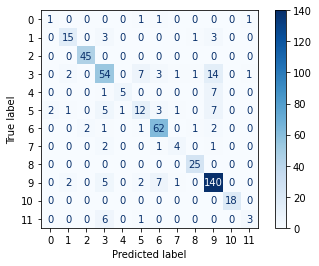


F1 scores: [0.28571429 0.71428571 0.97826087 0.675      0.52631579 0.42857143
 0.84931507 0.53333333 0.94339623 0.84592145 1.         0.4       ]

Mean F1 : 0.6816761805002471

Accuracy : 0.7901234567901234


In [ ]:
val_acc = show_confusion(ensemble_model, test_dataset)

In [ ]:
%load_ext cython

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.21796338, 0.09321781, 0.0925724 , 0.09995806, 0.12031111,
        0.10027895, 0.0949325 , 0.09290968, 0.09656119, 0.09643593,
        0.09037171, 0.13991877],
       [0.38186691, 0.23693246, 0.26376609, 0.25101597, 0.08280735,
        0.31261854, 0.2732046 , 0.26857985, 0.26584331, 0.2638701 ,
        0.27190615, 0.10914322],
       [0.17547636, 0.11140375, 0.11275014, 0.10263177, 0.14438636,
        0.10685097, 0.11232416, 0.11219857, 0.11685121, 0.11605112,
        0.1104329 , 0.10728074],
       [0.        , 0.18486718, 0.16423027, 0.19503122, 0.15522967,
        0.13001522, 0.16013979, 0.13042362, 0.15723078, 0.16318719,
        0.16751515, 0.09590558],
       [0.21934545, 0.10954081, 0.11285918, 0.11427609, 0.13283545,
        0.0956035 , 0.11256711, 0.14959809, 0.10600742, 0.11287647,
        0.11358813,

In [ ]:
%%cython
from __main__ import ensemble_model
name = "./gdrive/MyDrive/ann_dataset/modelss/F1Tabu07942"
ensemble_model.save(name)

# Debugging on W

In [ ]:
# try removing models
# using custom W weights for models
Wavg = WeightedAverageLayer(np.array([1,1,1,1,1,1,1,1,1])[:,None] * W)

['./gdrive/MyDrive/ann_dataset/W_ensemble/W0.7736625514403292', './gdrive/MyDrive/ann_dataset/W_ensemble/W0.7757201646090535', './gdrive/MyDrive/ann_dataset/W_ensemble/W07777777777777778', './gdrive/MyDrive/ann_dataset/W_ensemble/W0.779835390946502', './gdrive/MyDrive/ann_dataset/W_ensemble/importance0.7880658436213992', './gdrive/MyDrive/ann_dataset/W_ensemble/WW0.7880658436213992', './gdrive/MyDrive/ann_dataset/W_ensemble/WW0.7901234567901234', './gdrive/MyDrive/ann_dataset/W_ensemble/importance0.7901234567901234', './gdrive/MyDrive/ann_dataset/W_ensemble/WW0.7716049382716049', './gdrive/MyDrive/ann_dataset/W_ensemble/importance0.7716049382716049', './gdrive/MyDrive/ann_dataset/W_ensemble/WW0.7695473251028807', './gdrive/MyDrive/ann_dataset/W_ensemble/importance0.7695473251028807', './gdrive/MyDrive/ann_dataset/W_ensemble/WW0.7736625514403292', './gdrive/MyDrive/ann_dataset/W_ensemble/importance0.7736625514403292', './gdrive/MyDrive/ann_dataset/W_ensemble/WW0.7757201646090535', './gd

In [ ]:
for i,m in enumerate(models):
    m._name = f"{m.name}{i}"
model_input = tf.keras.Input(shape=(36, 6))
model_outputs = [model(model_input) for model in models]
ensemble_output = Wavg(model_outputs)
ensemble_model = tf.keras.Model(inputs=model_input, outputs=ensemble_output)

In [ ]:
val_acc = show_confusion(ensemble_model, test_dataset)

In [ ]:
np.array([0,1,1,1,1,1,1,0,1])[:,None] * W

Iteration 0
Feature 0
perturbation
16/16 [==============================] - 40s 793ms/step
0.7777777777777778
[[1.45501561]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]]
16/16 [==============================] - 35s 763ms/step
0.779835390946502
[[1.09903945]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]]


# Black box optimization for importance vector in ensemble
We tried to randomly change iteratively the weight given to each model tabu search like and also to include random perturbation on all the class weights for each model

In [ ]:
MODEL_SOURCE = "./gdrive/MyDrive/ann_dataset/W_ensemble"
paths_W = []
for f in os.listdir(f"{MODEL_SOURCE}"):
    paths_W.append(f"{MODEL_SOURCE}/{f}")
print(paths_W)

In [ ]:
# load baseline
with open('./gdrive/MyDrive/ann_dataset/W_ensemble/W_F1', "rb") as f:
 W_F1 = pickle.load(f)

In [ ]:
def get_perturbation_vextor(epsilon=0.05):
    E = np.zeros(12)
    for i in range(12):
            E[i] = np.random.uniform(0,epsilon)
    return E

In [ ]:
""" Random importances iterations to try to weigth models in the ensemble based on their impact on the accuracy"""
ITERATIONS = 100

"""with open("./W07777777777777778", "rb") as f:
    W_old = pickle.load(f)"""
#new_importance = importances.copy()
new_importance = np.ones(9)[:,None]
importances = np.ones(9)[:,None]
old_accuracy = 0.7942386831275721
id_exp = 8

W_F1 = W


for _ in range(ITERATIONS):
    print(f"Iteration {_}")
    for i in range(9):
      print(f"Feature {i}")
      for trial in range(4):

        if np.random.choice([True, False]):
          # ** scale case **

          new_importance = importances.copy()
          # generate random step
          random_step = np.random.uniform(0.05, 0.5)
          if np.random.choice([True, False]):
              random_step = random_step * -1
          # buil new step vector
          new_importance[i] = importances[i] + random_step
          print(new_importance)
          W_new = new_importance * W_F1
        else:

          # ** perturbation case **
          W_new = W_F1[:]
          W_new[i] = get_perturbation_vextor(0.05)
          print("perturbation")

        #%% Apply weights to the ensemble
        Wavg = WeightedAverageLayer(W_new)
        for ii,m in enumerate(models):
            m._name = f"{m.name}{ii}"
        model_input = tf.keras.Input(shape=(36, 6))
        model_outputs = [model(model_input) for model in models]
        ensemble_output = Wavg(model_outputs)
        ensemble_model = tf.keras.Model(inputs=model_input, outputs=ensemble_output)
        #%%
       
        accuracy = get_validation_acc(ensemble_model, test_dataset)
        print(accuracy)

        # save if improvement
        if accuracy > old_accuracy:
            print(f"New importance vector ->\n {new_importance}")
            old_accuracy = accuracy
            importances = new_importance.copy()
            with open(f"./gdrive/MyDrive/ann_dataset/W_ensemble/WF1{accuracy}", "wb") as f:
                pickle.dump(W_new, f)
            """with open(f"./gdrive/MyDrive/ann_dataset/W_ensemble/f1importance{accuracy}", "wb") as f:
                pickle.dump(new_importance, f)"""

        del W_new

In [ ]:
# save on drive
%%cython
from __main__ import ensemble_model
name = "./gdrive/MyDrive/ann_dataset/modelss/0788"
ensemble_model.save(name)

# JAX autograd enseble optimization [ Failed :( ]

here we tried to compute the gradient with respect to the weights given to the ensemble with Jax library using autograd but the code was breaking due to incompatibility of tensors and jnp ndarrays 

In [ ]:
import jax.numpy as jnp
import numpy as np
import jax

NotImplementedError: ignored

In [ ]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [ ]:
class WeightedAverageLayer(tf.keras.layers.Layer):
    def __init__(self, w, **kwargs):
        super(WeightedAverageLayer, self).__init__(**kwargs)
        self.w = w

    def call(self, inputs):
        #return tf.tensordot(tf.transpose(inputs), self.w, axes=1)
        return jnp.array(self.w) * jnp.array(inputs)

StagingError: ignored

In [ ]:
def ensemble_jax(params):
  ensemble_model.layers[-1].w = params
  ensemble_model.compile()
  return get_validation_acc(ensemble_model, test_dataset)

In [ ]:
def get_jnp_random_vect(size):
  # build a list/array of random numbers
  numbers = []
  for _ in range(size):
      numbers.append(random.uniform(0, 1/size))
  # normalise the original list using the sum
  return jnp.array(numbers) / jnp.sum(numbers)

In [ ]:
init_w = jnp.array(get_probability_vect(len(models)))
Wavg = WeightedAverageLayer(init_w[:,None])

In [ ]:
for i,m in enumerate(models):
  m._name = f"{m.name}{i}" 
model_input = tf.keras.Input(shape=(36, 6))
model_outputs = [model(model_input) for model in models]
ensemble_output = Wavg(model_outputs)
ensemble_model = tf.keras.Model(inputs=model_input, outputs=ensemble_output)

In [ ]:
ann_grad = jax.grad(ensemble_jax, argnums=0)

AttributeError: ignored

In [ ]:
w = get_random_vect(len(models))
ann_grad(np.array([[w]]))

In [ ]:
models[3].history

In [ ]:
import matplotlib.pyplot as plt


In [ ]:
# load scaler
with open("./gdrive/MyDrive/ann_dataset/HW2/", "rb") as f:
  history = pickle.load(f)

In [ ]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history[metric])
plt.plot(history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()